<a href="https://colab.research.google.com/github/Pritush09/DeepLearning-Pytorch/blob/master/02_NN_Classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Make classification data and get it ready
Let's begin by making some data.

We'll use the make_circles() method from Scikit-Learn to generate two circles with different coloured dots.

In [2]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]



Looks like there's two X values per one y value.

In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

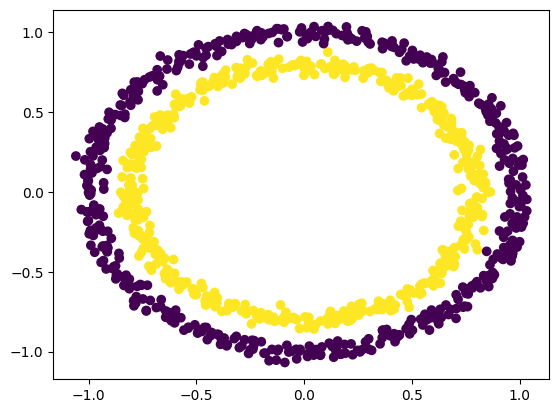

In [6]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, )

This dataset is often what's considered a toy problem (a problem that's used to try and test things out on) in machine learning.

But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

#Input and output shapes
One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.


And there's no surefire way to making sure they won't happen, they will.

What you can do instead is continaully familiarize yourself with the shape of the data you're working with.

I like referring to it as input and output shapes.

Ask yourself:

"What shapes are my inputs and what shapes are my outputs?"

Let's find out.

In [7]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

#Turn data into tensors and create train and test splits
We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:

* Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
* Split our data into training and test sets (we'll train a model on the training set to learn the patterns between X and y and then evaluate those learned patterns on the test dataset).

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))


Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function train_test_split() from Scikit-Learn.

We'll use test_size=0.2 (80% training, 20% testing) and because the split happens randomly across the data, let's use random_state=42 so the split is reproducible.

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

 # Building a model
We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
Constructing a model by subclassing nn.Module.
Defining a loss function and optimizer.
Creating a training loop (this'll be in the next section).
The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and torch.nn as well as setting up device agnostic code.

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Excellent, now device is setup, we can use it for any data or models we create and PyTorch will handle it on the CPU (default) or GPU if it's available.

How about we create a model?

We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as ouputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:

* Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
* Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
* Defines a forward() method containing the forward pass computation of the model.
* Instantiates the model class and sends it to the target device.

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between self.layer_1 and self.layer_2.

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

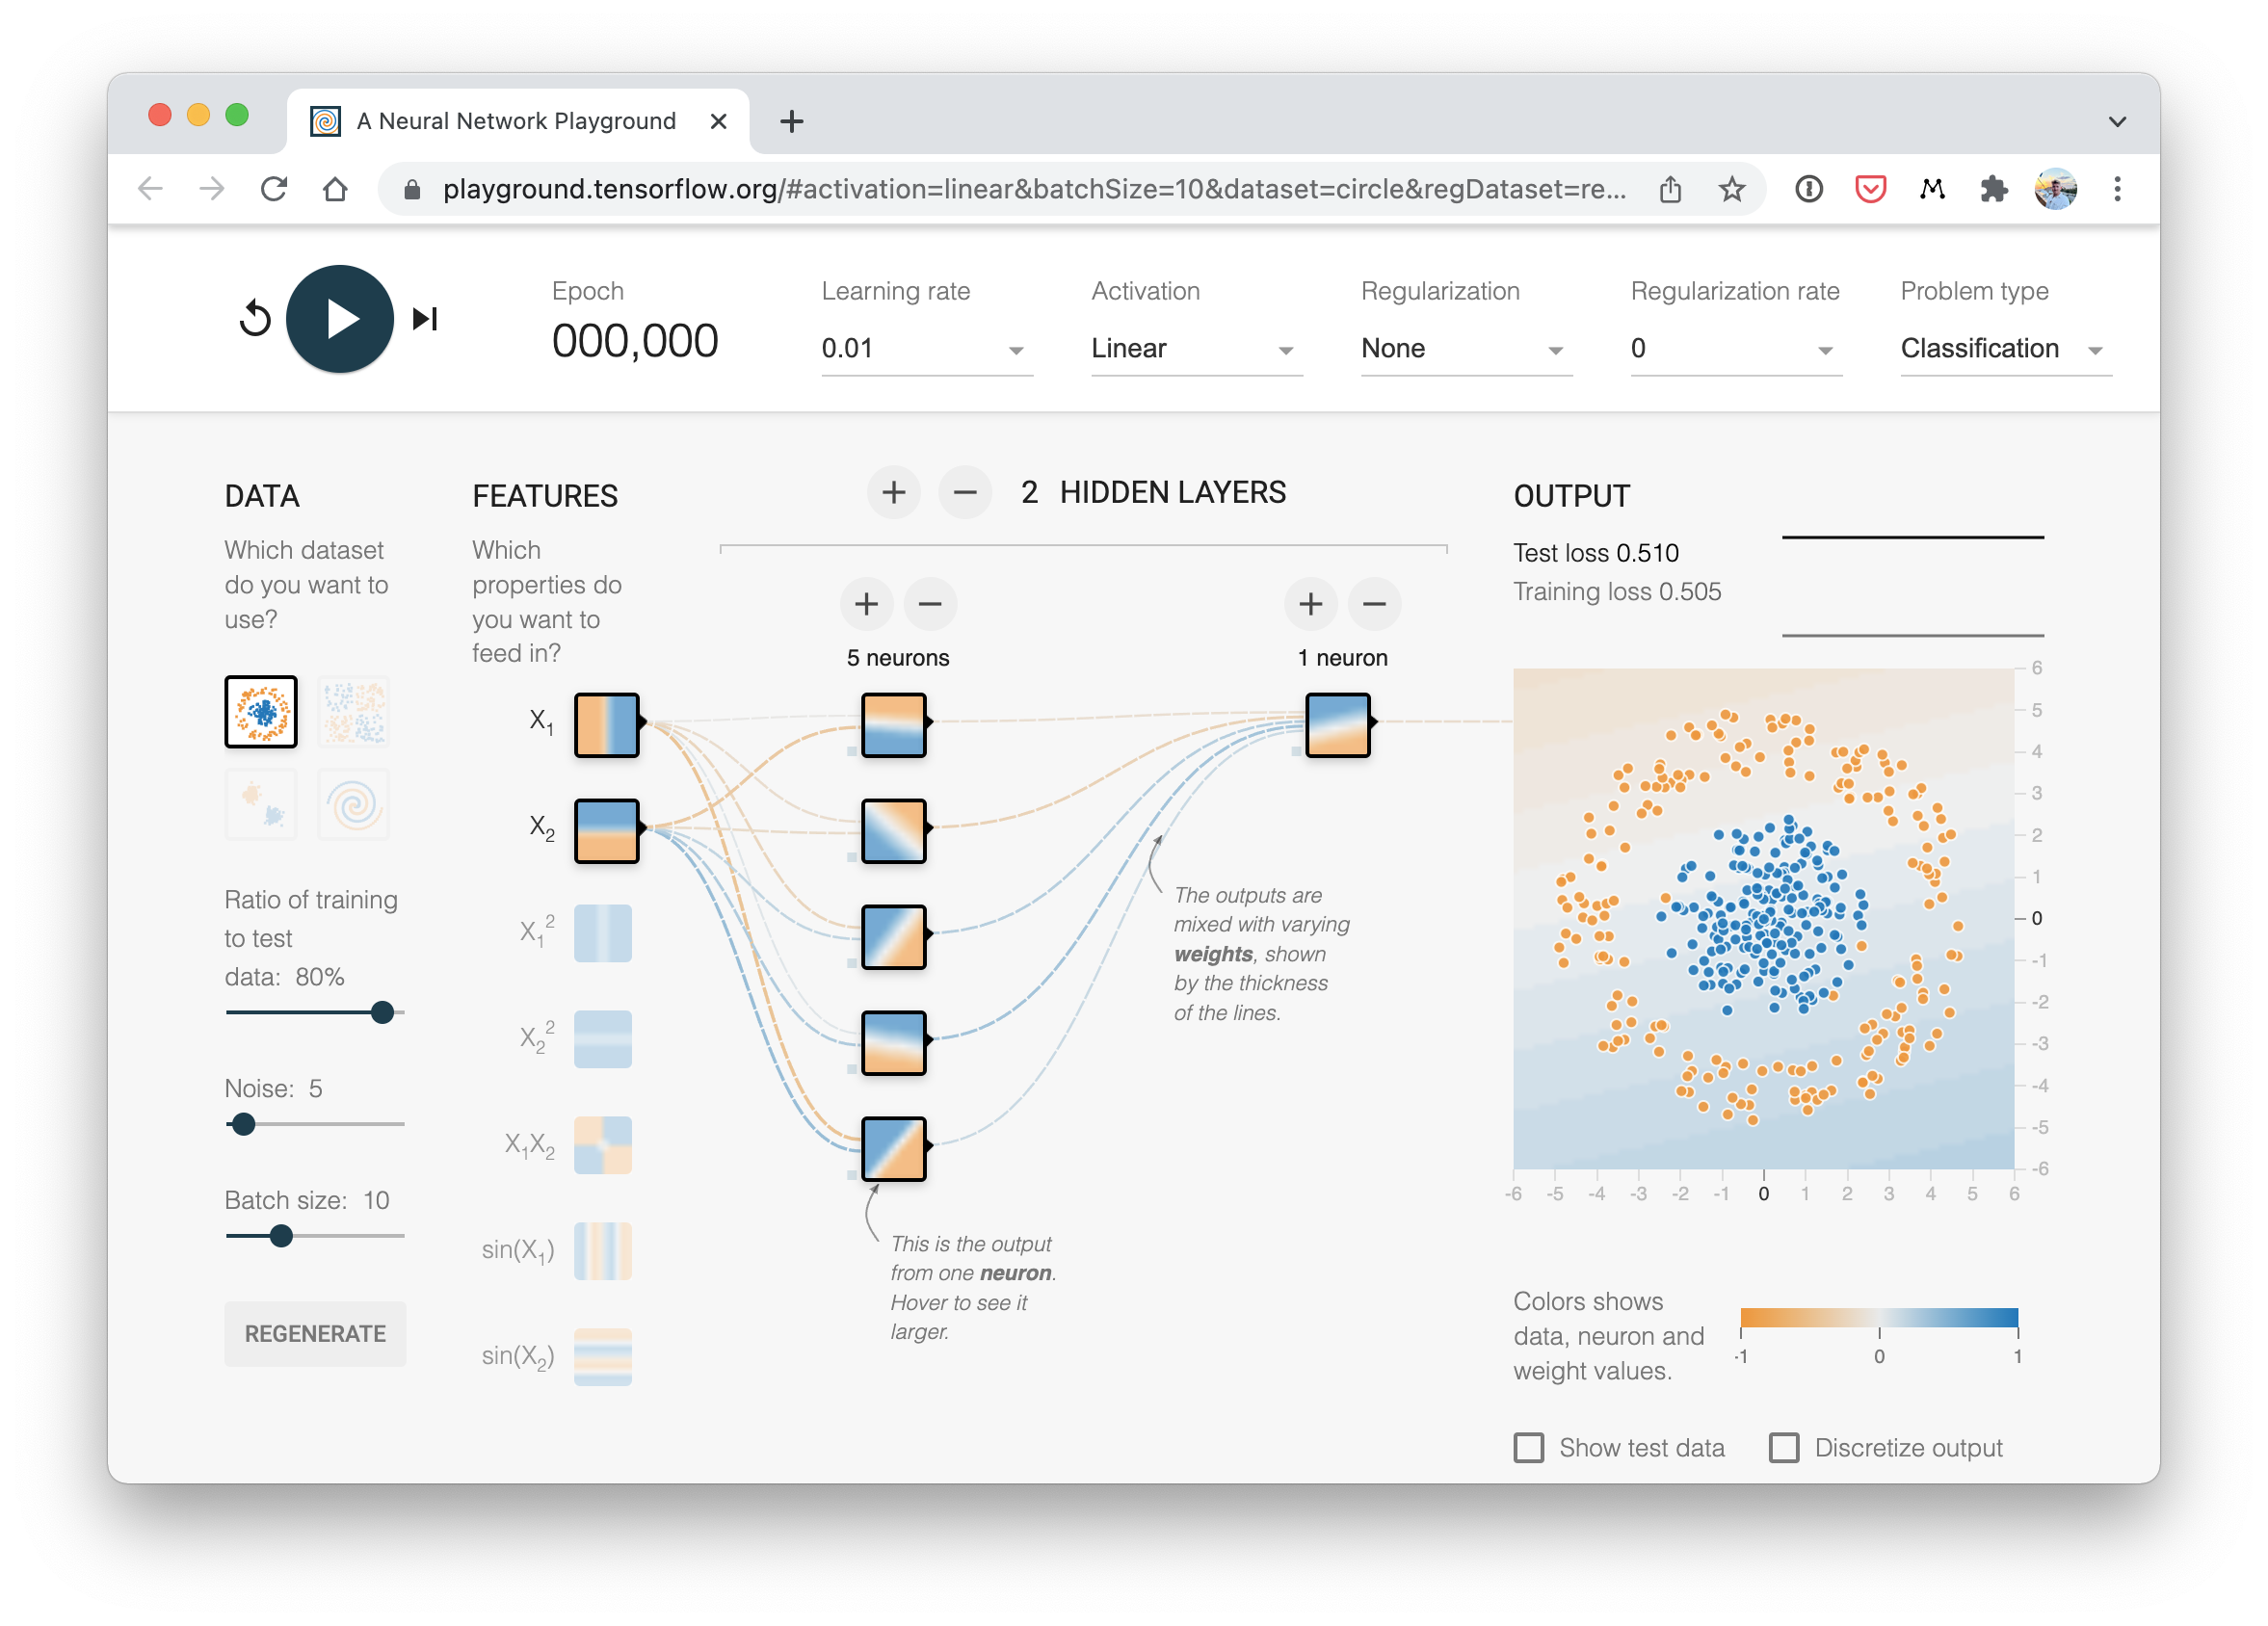

this is from Tensorflow playground
https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94801&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

nn.sequemtial implementation of this https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear

# Overview on sequential

A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in. The forward() method of Sequential accepts any input and forwards it to the first module it contains. It then “chains” outputs to inputs sequentially for each subsequent module, finally returning the output of the last module.

The value a Sequential provides over manually calling a sequence of modules is that it allows treating the whole container as a single module, such that performing a transformation on the Sequential applies to each of the modules it stores (which are each a registered submodule of the Sequential).

What’s the difference between a Sequential and a torch.nn.ModuleList? A ModuleList is exactly what it sounds like–a list for storing Module s! On the other hand, the layers in a Sequential are connected in a cascading way.

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)


Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.8581],
        [0.7599],
        [0.9302],
        [0.8384],
        [0.6362],
        [0.5785],
        [0.5351],
        [0.4919],
        [0.9425],
        [0.7501]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#Setup loss function and optimizer
We've setup a loss (also called a criterion or cost function) and optimizer before in notebook 01.

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, so can too the Adam optimizer (torch.optim.Adam()).

# Loss function/Optimizer	Problem type	PyTorch Code
* Stochastic Gradient Descent (SGD) optimizer	Classification, regression, many others.	torch.optim.SGD()
* Adam Optimizer	Classification, regression, many others.	torch.optim.Adam()
* Binary cross entropy loss	Binary classification	torch.nn.BCELossWithLogits or torch.nn.BCELoss
* Cross entropy loss	Mutli-class classification	torch.nn.CrossEntropyLoss
* Mean absolute error (MAE) or L1 Loss	Regression	torch.nn.L1Loss
Mean squared error (MSE) or L2 Loss	Regression	torch.nn.MSELoss


#PyTorch has two binary cross entropy implementations:

1. torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).

2. torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss().

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use torch.optim.SGD() to optimize the model parameters with learning rate 0.1.

In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

Now let's also create an evaluation metric.

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

Of course, you could argue both of these are doing the same thing but evaluation metrics offer a different perspective.

After all, when evaluating your models it's good to look at things from multiple points of view.

There are several evaluation metrics that can be used for classification problems but let's start out with accuracy.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [16]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.8581],
        [0.7599],
        [0.9302],
        [0.8384],
        [0.6362]], grad_fn=<SliceBackward0>)


Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

y
=
x
⋅
W
e
i
g
h
t
s.
T
+
b
i
a
s

The raw outputs (unmodified) of this equation (
y
) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data (
x
 in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.7023],
        [0.6813],
        [0.7171],
        [0.6981],
        [0.6539]], grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)

If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

https://i.stack.imgur.com/zto5q.png

In [19]:
# comparing with the y
y_test[:5]

tensor([1., 0., 1., 0., 1.])

his means we'll be able to compare our models predictions to the test labels to see how well it's going.

To recap, we converted our model's raw outputs (logits) to predicition probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

`Note:` The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

In [20]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.76571, Accuracy: 50.00% | Test loss: 0.75462, Test acc: 50.00%
Epoch: 10 | Loss: 0.71744, Accuracy: 50.00% | Test loss: 0.71213, Test acc: 50.00%
Epoch: 20 | Loss: 0.70278, Accuracy: 54.62% | Test loss: 0.69933, Test acc: 55.50%
Epoch: 30 | Loss: 0.69801, Accuracy: 51.75% | Test loss: 0.69530, Test acc: 55.00%
Epoch: 40 | Loss: 0.69624, Accuracy: 50.88% | Test loss: 0.69395, Test acc: 53.50%
Epoch: 50 | Loss: 0.69543, Accuracy: 50.75% | Test loss: 0.69344, Test acc: 50.00%
Epoch: 60 | Loss: 0.69494, Accuracy: 51.12% | Test loss: 0.69322, Test acc: 50.00%
Epoch: 70 | Loss: 0.69460, Accuracy: 50.25% | Test loss: 0.69312, Test acc: 51.00%
Epoch: 80 | Loss: 0.69433, Accuracy: 50.38% | Test loss: 0.69307, Test acc: 50.00%
Epoch: 90 | Loss: 0.69412, Accuracy: 50.50% | Test loss: 0.69306, Test acc: 50.50%
Epoch: 100 | Loss: 0.69394, Accuracy: 50.62% | Test loss: 0.69307, Test acc: 49.50%
Epoch: 110 | Loss: 0.69379, Accuracy: 50.88% | Test loss: 0.69310, Test acc: 48.50%
Epo

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

# Make predictions and evaluate the model
From the metrics it looks like our model is random guessing.

How could we investigate this further?

I've got an idea.

The data explorer's motto!

"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

* resource of the function is madewithml website

In [21]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

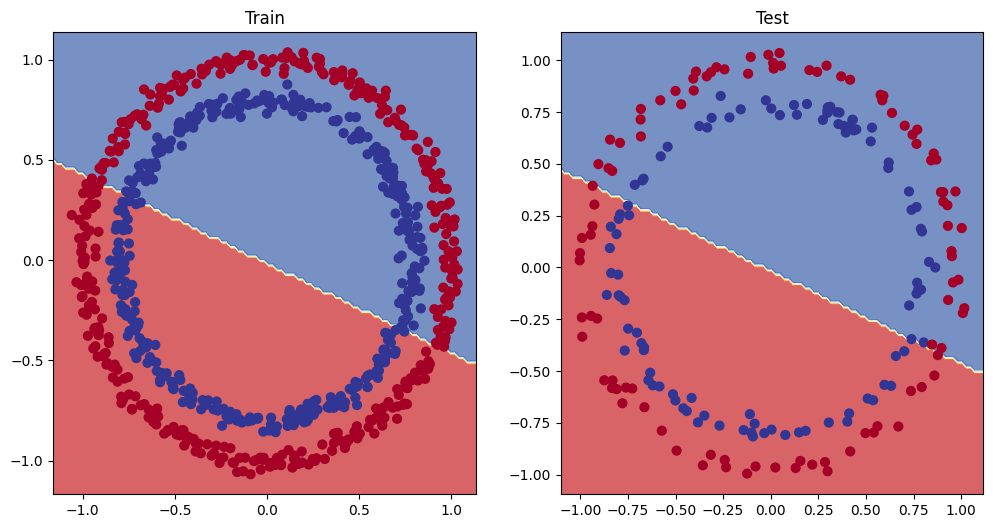

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving a model (from a model perspective)
Let's try to fix our model's underfitting problem.

Focusing specifically on the model (not the data), there are a few ways we could do this.

Model improvement technique*	What does it do?

Add more layers	Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper.

Add more hidden units	Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.

Fitting for longer (more epochs)	Your model might learn more if it had more opportunities to look at the data.

Changing the activation functions	Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).

Change the learning rate	Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.

Change the loss function	Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.

Use transfer learning	Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.

`Note:` because you can adjust all of these by hand, they're referred to as hyperparameters*.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

In [23]:
# Adding a more layer to test whether the model is doing any better or not
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


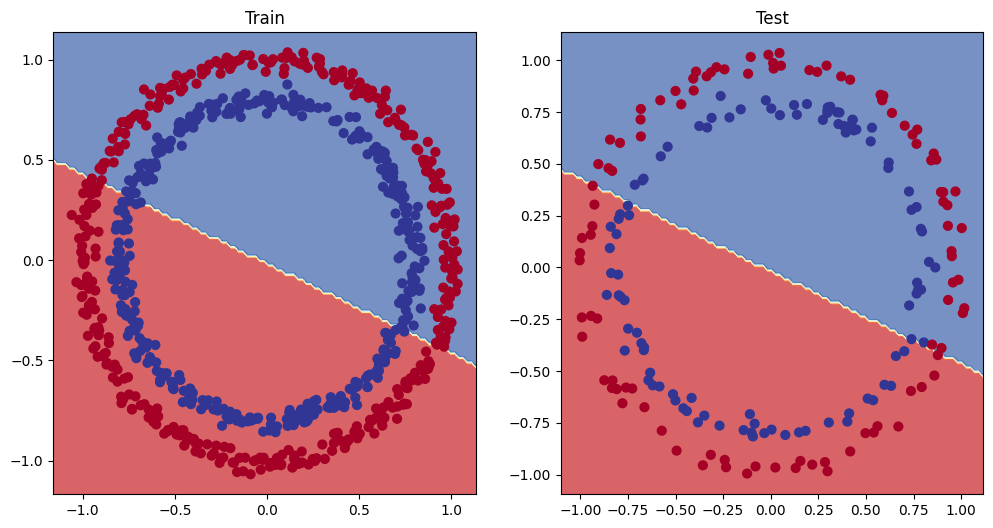

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Note: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount data or the model size/design to reduce overfitting.

* this above statement is for the training the large model

# NON Linearity 

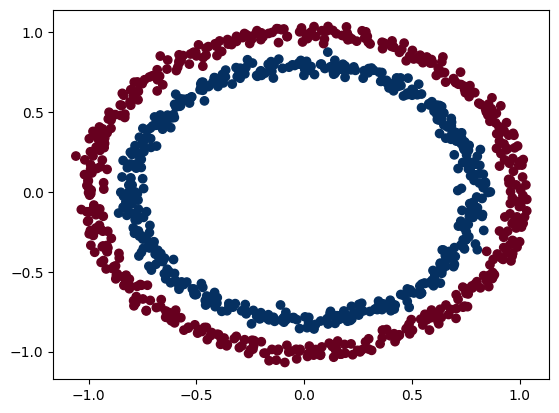

In [27]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [28]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# Building a model with non-linearity
Now here comes the fun part.

What kind of pattern do you think you could draw with unlimited straight (linear) and non-straight (non-linear) lines?

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use non-linear actviation functions?

PyTorch has a bunch of ready-made non-linear activation functions that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, torch.nn.ReLU()).

In [29]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Question: Where should I put the non-linear activation functions when constructing a neural network?

A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantine, best to experiment, experiment, experiment.

In [30]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

#Training a model with non-linearity

In [31]:
# Fit the model
torch.manual_seed(42)
epochs = 3000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

# Evaluating a model trained with non-linear activation functions

In [32]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

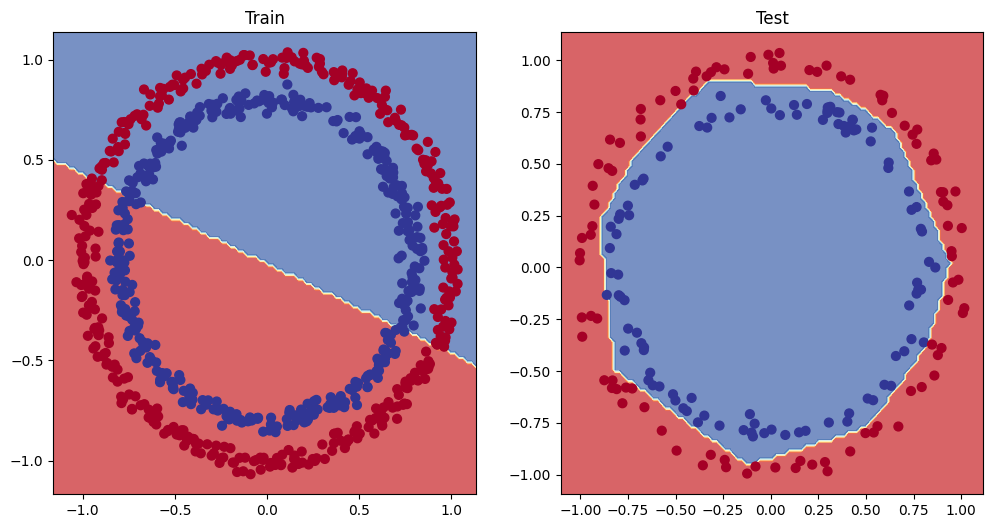

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Replicating non-linear activation functions

`Note:` Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

In [34]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

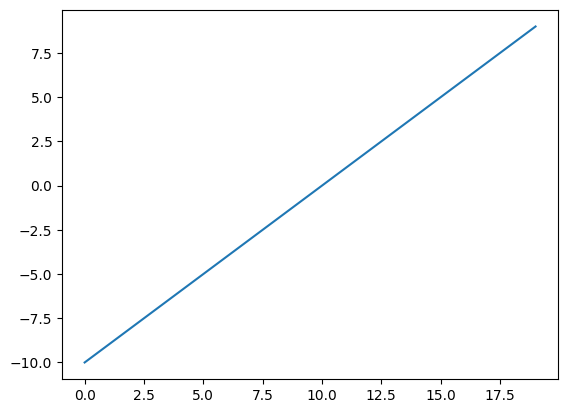

In [35]:
# Visualize the toy tensor
plt.plot(A);

In [36]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

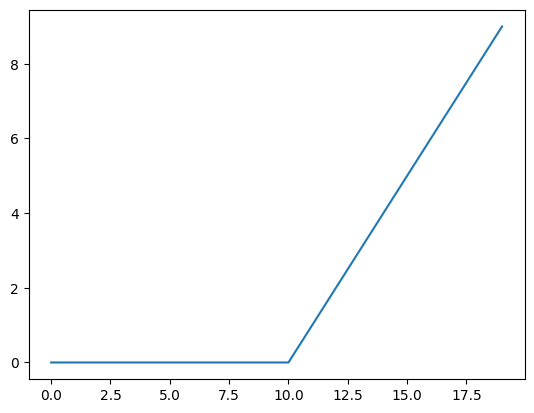

In [37]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [38]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

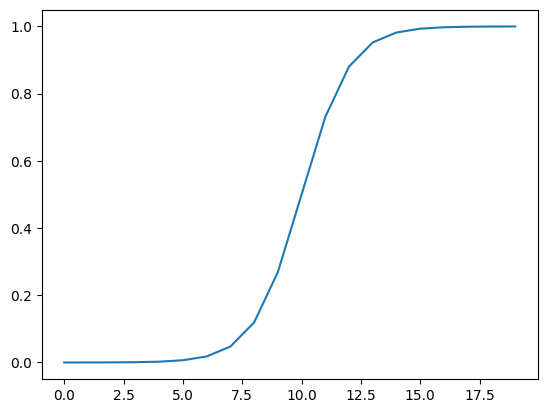

In [39]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A))

[non-linear activation functions](https://pytorch.org/docs/stable/nn.html)<- more here 

# Putting things together by building a multi-class PyTorch model

### Creating mutli-class classification data
To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's make_blobs() method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

* Create some multi-class data with make_blobs().
* Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
* Split the data into training and test sets using train_test_split().
* Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


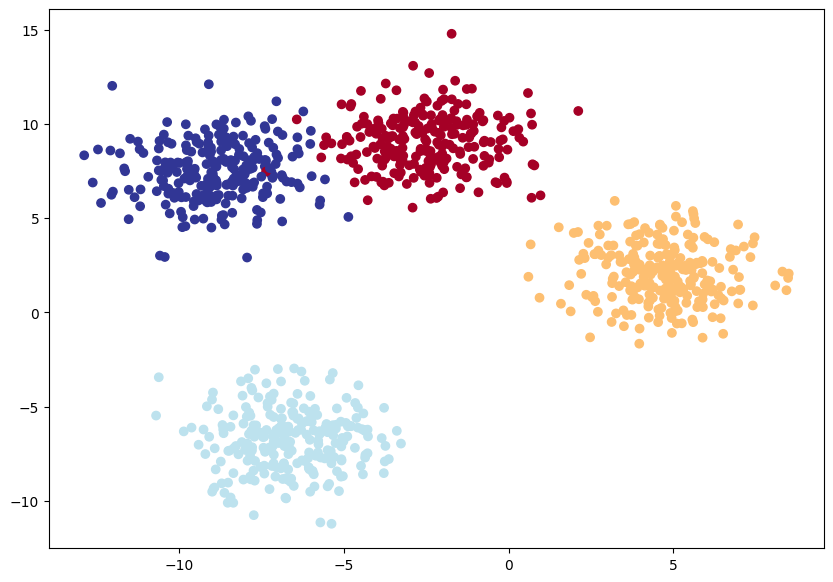

In [40]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [41]:
X_blob_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]])

In [42]:
y_blob_train

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
        3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
        0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
        2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
        1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
        2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
        2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 3,

### Building a multi-class classification model in PyTorch
We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to model_3 but this still capable of handling multi-class data?

To do so, let's create a subclass of nn.Module that takes in three hyperparameters:

* input_features - the number of X features coming into the model.
* output_features - the ideal numbers of output features we'd like (this will be equivalent to NUM_CLASSES or the number of classes in your multi-class classification problem).
* hidden_units - the number of hidden neurons we'd like each hidden layer to use.

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Creating a loss function and optimizer for a multi-class PyTorch model
Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.

In [45]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

###Getting prediction probabilities for a multi-class PyTorch model

In [46]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [47]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

It looks like we get one value per feature of each sample.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [48]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [49]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [50]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

`Note:` To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

In [51]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


###Making and evaluating predictions with a PyTorch multi-class model
It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [52]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])


Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (y_blob_test) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using torch.softmax()) then to prediction labels (by taking the argmax() of each sample).

`Note:` It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [53]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")


Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


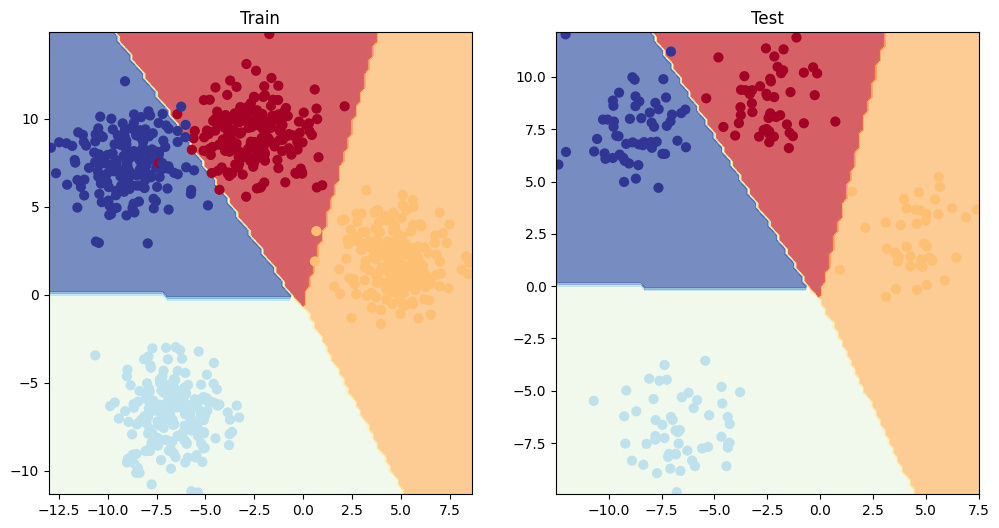

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)